In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter
import datetime as dt
import pandas as pd

from stable_baselines.common.policies import MlpLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.ppo2 import PPO2
from stable_baselines import bench, logger
from stable_baselines.results_plotter import load_results, ts2xy

from importlib import reload
from time import time
import os.path

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%Y-%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(x)
        if ind >= len(self.dates) or ind < 0:
            return ''
        else:
            return self.dates[ind].strftime(self.fmt)

def evaluate(model, environment, num_steps=40000):
    pnl = []
    dates = []
    trans_cost = []
    action_ls = []
    obs = environment.reset()
    for i in range(num_steps):
        # _states are only useful when using LSTM policies
        action, _states = model.predict(obs, deterministic=True)
        # here, action, rewards and dones are arrays, because we are using vectorized env
        obs, rewards, dones, info = environment.step(action)
        date = info[0]["date"].to_pydatetime()
        cost = info[0]["transaction_cost"]
        # Stats
        pnl.append(rewards[0])
        dates.append(date)
        trans_cost.append(cost)
        action_ls.append(action)
        if dones[0]:
            break
    
    pnl = np.array(pnl)
    dates = np.array(dates)
    actions = np.array(action_ls)
  
    return pnl, dates, trans_cost, actions


def evaluate_short(model, environment, num_steps=40000):
    pnl = []
    obs = environment.reset()
    for i in range(num_steps):
        # _states are only useful when using LSTM policies
        action, _states = model.predict(obs, deterministic=True)
        # here, action, rewards and dones are arrays, because we are using vectorized env
        obs, rewards, dones, info = environment.step(action)
        pnl.append(rewards[0])
        if dones[0]:
            break
    return sum(pnl)


def annual_sharpe(pnl):
    mean = pnl.mean()
    var = pnl.std()
    day_sharpe = (mean / var) * np.sqrt(390)
    year_sharpe = day_sharpe * np.sqrt(252)
    return year_sharpe

def annual_return(pnl, principal=1000000):    
    ret = pnl / principal
    return np.mean(ret) * 390 * 252

def annual_volatility(pnl, principal=1000000):
    log_ret = np.log(1 + pnl / principal)
    return log_ret.std() * np.sqrt(252)

def maximum_drawdown(pnl):
    cum_pnl = np.cumsum(pnl)
    ind = np.argmax(np.maximum.accumulate(cum_pnl) - cum_pnl)
    return (np.maximum.accumulate(cum_pnl)[ind] - cum_pnl[ind]) / np.maximum.accumulate(cum_pnl)[ind]

def annual_turnover(weights):
    turnover = np.sum(np.abs(weights[1:] - weights[:-1])) / weights.shape[0]
    return turnover * 390 * 252

In [20]:
# Define your parameters here
episode_len = 120
file_dir = "../COMS-W4995-Deep-Learning-Project"

# Training

In [3]:
import equity_env

In [66]:
reload(equity_env)

<module 'equity_env' from '/home/jupyter/RL_project/equity_env.py'>

In [41]:
# train
env = equity_env.EquityEnv(split_data=True)
env = DummyVecEnv([lambda: env])
model = PPO2(MlpLstmPolicy, env, n_steps=240, learning_rate=0.000001, verbose=0, nminibatches=1, 
             policy_kwargs={"n_lstm":36, "layers":[36,36]}, tensorboard_log="./equity_train_tensorboard/")

-- Data Loaded --
-- Environment Created --


/home/jupyter/.local/lib/python3.5/site-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


In [42]:
start = time()
model.learn(total_timesteps=episode_len*200, tb_log_name="0bps_new_env")
end = time()
t = end - start
print("Takes %d s to run" % t)

Takes 492 s to run


In [ ]:
# yeah maybe need a better

In [67]:
valid_env = equity_env.EquityEnv(split_data=False, test_option="develop")
valid_env = DummyVecEnv([lambda: valid_env])

-- Data Loaded --
-- Environment Created --


In [68]:
pnl, dates, trans_cost, actions = evaluate(model, valid_env)

In [4]:
import optunity

In [8]:
search = {"episode_len": {"120": {"ent_coef": [0.01, 0.1],
                                  "vf_coef": [0.3, 0.8],
                                  "cliprange": [0.1, 0.5],
                                  "learning_rate": [1e-7, 1e-3],
                                  "n_lstm": [8, 256]},
                          "480": {"ent_coef": [0.01, 0.1],
                                  "vf_coef": [0.3, 0.8],
                                  "cliprange": [0.1, 0.5],
                                  "learning_rate": [1e-7, 1e-3],
                                  "n_lstm": [8, 256]}, 
                          "1200": {"ent_coef": [0.01, 0.1],
                                  "vf_coef": [0.3, 0.8],
                                  "cliprange": [0.1, 0.5],
                                  "learning_rate": [1e-7, 1e-3],
                                  "n_lstm": [8, 256]}}}

In [6]:
def performance(episode_len, ent_coef, vf_coef, cliprange, learning_rate, n_lstm):
    ep_len = int(episode_len)
    env = equity_env.EquityEnv(split_data=True, episode_length=ep_len)
    env = DummyVecEnv([lambda: env])
    model = PPO2(MlpLstmPolicy, env, n_steps=240, ent_coef=ent_coef, vf_coef=vf_coef,
                 cliprange=cliprange, learning_rate=learning_rate, verbose=0, 
                 nminibatches=1, policy_kwargs={"n_lstm":int(n_lstm), "layers":[36,36]})
    episode_num = int(200 / (ep_len / 120))
    model.learn(total_timesteps=ep_len*episode_num)
    
    dev_env = equity_env.EquityEnv(split_data=False, test_option="develop")
    dev_env = DummyVecEnv([lambda: dev_env])
    return evaluate_short(model, valid_env)

In [83]:
t = time()
res = performance("120", 0.01, 0.5, 0.2, 1e-5, 32)
print(time() - t)

-- Data Loaded --
-- Environment Created --


/home/jupyter/.local/lib/python3.5/site-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


-- Data Loaded --
-- Environment Created --
788.1843731403351


In [ ]:
t = time()
optimal_configuration, info, _ = optunity.maximize_structured(performance, search_space=search, num_evals=50)
print(time() - t)

-- Data Loaded --
-- Environment Created --




Instructions for updating:
Use keras.layers.flatten instead.


/home/jupyter/.local/lib/python3.5/site-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [14]:
t

1572928359.9223826

# 2. In-Sample test: no transaction cost

In [4]:
env_in_0 = gym.make('Equity-insample-0bps-v0')
env_in_0 = DummyVecEnv([lambda: env_in_0])
model_train_0 = PPO2.load("no_trans_cost_36dim_state_100000", env_in_0)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.


d:\school related\grad school course\projects\rl_package\stable-baselines\stable_baselines\common\policies.py:288: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


Instructions for updating:
Use tf.cast instead.


In [58]:
# Train reward before training
pnl, dates, costs, actions = evaluate(model_train_0, env_in_0, num_steps=40000)

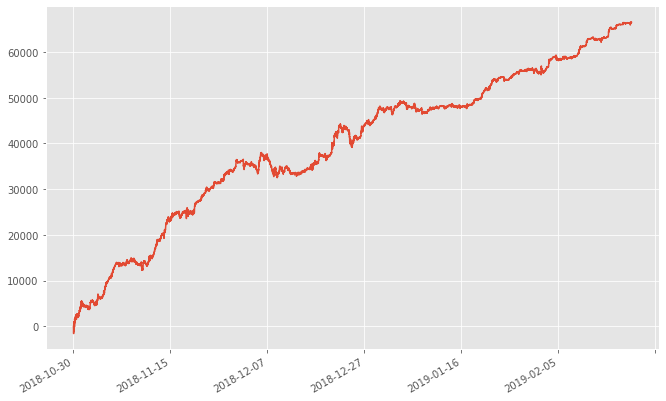

In [6]:
plt.style.use("ggplot")
formatter = MyFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl.shape[0]), np.cumsum(pnl))
fig.autofmt_xdate()
plt.show()

### return statistics

In [6]:
annual_sharpe(pnl)

11.423954029545452

In [63]:
annual_return(pnl)

0.22721872624854883

In [27]:
annual_volatility(pnl)

0.0010071221607839973

In [29]:
maximum_drawdown(pnl)

0.14486884

In [61]:
annual_turnover(actions)

18432.459533687168

# 3. In Sample Test: 2bps transaction cost

In [64]:
env_in_2 = gym.make('Equity-insample-2bps-v0')
env_in_2 = DummyVecEnv([lambda: env_in_2])
model_in_2_bad = PPO2.load("no_trans_cost_36dim_state_100000", env_in_2)

d:\school related\grad school course\projects\rl_package\stable-baselines\stable_baselines\common\policies.py:288: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


In [74]:
pnl1, dates1, costs1, actions1 = evaluate(model_in_2_bad, env_in_2, num_steps=40000)

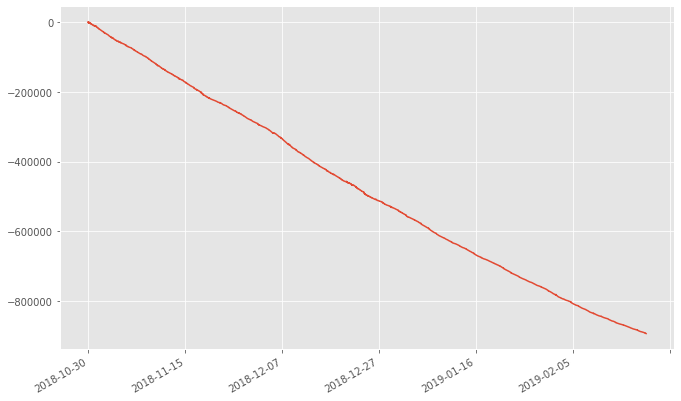

In [75]:


plt.style.use("ggplot")
formatter = MyFormatter(dates1)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl1.shape[0]), np.cumsum(pnl1))
fig.autofmt_xdate()
plt.show()

### return statistics

In [76]:
annual_sharpe(pnl1)

-146.07269442703708

In [77]:
annual_return(pnl1)

-3.046950255332767

In [78]:
annual_volatility(pnl1)

0.001056268033277625

In [79]:
maximum_drawdown(pnl1)

-430909.53

In [81]:
annual_turnover(actions)

18432.459533687168

# 4. In sample test, 2bps cost, trained with trx cost

In [29]:
env_in_2 = gym.make('Equity-insample-2bps-v0')
env_in_2 = DummyVecEnv([lambda: env_in_2])
model_in_2_good = PPO2.load("2bps_trans_cost_36dim_state_100000", env_in_2)

d:\school related\grad school course\projects\rl_package\stable-baselines\stable_baselines\common\policies.py:288: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


In [30]:
pnl2, dates2, costs2, actions2 = evaluate(model_in_2_good, env_in_2, num_steps=40000)

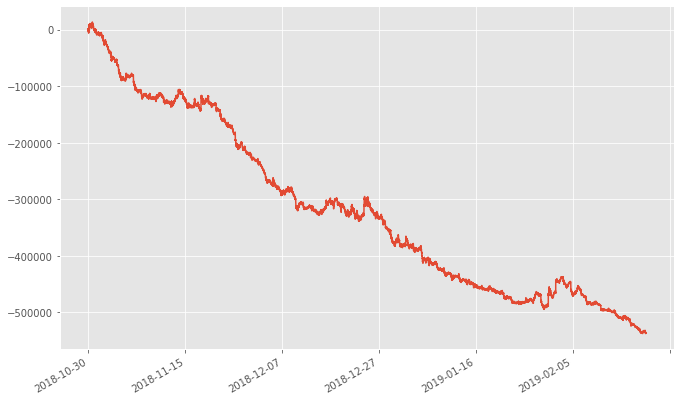

In [31]:
plt.style.use("ggplot")
formatter = MyFormatter(dates2)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl2.shape[0]), np.cumsum(pnl2))
fig.autofmt_xdate()
plt.show()

#### return statistics

In [32]:
annual_return(pnl2)

-1.8300276380291285

In [33]:
annual_volatility(pnl2)

0.011798193680626021

In [34]:
annual_sharpe(pnl2)

-7.845746040792746

In [35]:
maximum_drawdown(pnl2)

40.38723

In [36]:
annual_turnover(actions2)

13202.560410089758

## Strip transaction cost and see how it goes

In [37]:
env_in_0 = gym.make('Equity-insample-0bps-v0')
env_in_0 = DummyVecEnv([lambda: env_in_0])
model_in_0_good = PPO2.load("2bps_trans_cost_36dim_state_100000", env_in_0)

d:\school related\grad school course\projects\rl_package\stable-baselines\stable_baselines\common\policies.py:288: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


In [38]:
pnl3, dates3, costs3, actions3 = evaluate(model_in_0_good, env_in_0, num_steps=40000)

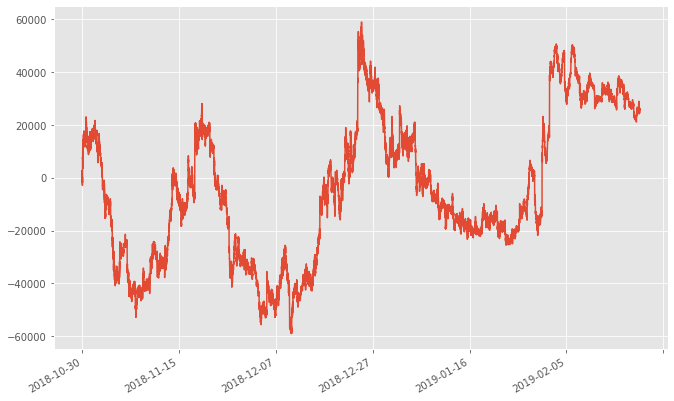

In [39]:
plt.style.use("ggplot")
formatter = MyFormatter(dates3)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl3.shape[0]), np.cumsum(pnl3))
fig.autofmt_xdate()
plt.show()

In [40]:
annual_return(pnl3)

0.08766874511997416

In [41]:
annual_volatility(pnl3)

0.011794473552269875

In [42]:
annual_sharpe(pnl3)

0.37593483974789715

In [43]:
maximum_drawdown(pnl3)

3.1136193

In [44]:
annual_turnover(actions3)

13202.560410089758

# 5. Out of Sample Test -- No transaction cost

In [47]:
env_test = gym.make('Equity-outsample-0bps-v0')
env_test = DummyVecEnv([lambda: env_test])
model_test = PPO2.load("no_trans_cost_36dim_state_100000", env_test)

d:\school related\grad school course\projects\rl_package\stable-baselines\stable_baselines\common\policies.py:288: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


In [48]:
pnl1, dates1, costs1, actions1 = evaluate(model_test, env_test, num_steps=40000)

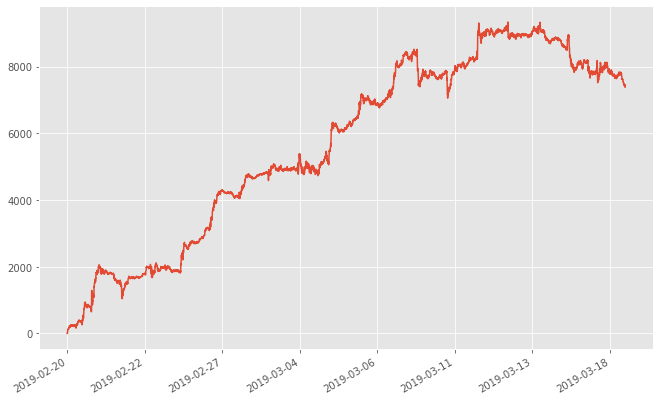

In [49]:
plt.style.use("ggplot")
formatter = MyFormatter(dates1)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl1.shape[0]), np.cumsum(pnl1))
fig.autofmt_xdate()
plt.show()

In [50]:
annual_return(pnl1)

0.10124997720631758

In [51]:
annual_volatility(pnl1)

0.0004902613320351047

In [52]:
annual_sharpe(pnl1)

10.457477889831399

In [53]:
maximum_drawdown(pnl1)

0.20948717

In [54]:
annual_turnover(actions1)

11981.453623251711

# 6. Out of Sample Test -- 2bps transaction cost

In [55]:
env_test_2 = gym.make('Equity-outsample-2bps-v0')
env_test_2 = DummyVecEnv([lambda: env_test_2])
model_test_2 = PPO2.load("2bps_trans_cost_36dim_state_250000", env_test_2)

d:\school related\grad school course\projects\rl_package\stable-baselines\stable_baselines\common\policies.py:288: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


In [56]:
pnl2, dates2, costs2, actions2 = evaluate(model_test_2, env_test, num_steps=40000)

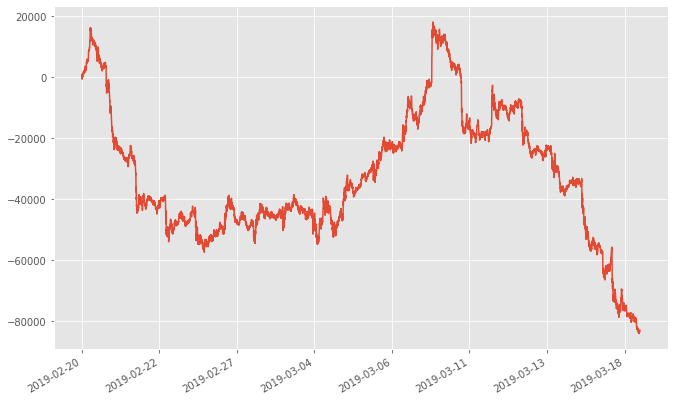

In [64]:
plt.style.use("ggplot")
formatter = MyFormatter(dates2)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl2.shape[0]), np.cumsum(pnl2))
fig.autofmt_xdate()
plt.show()

In [58]:
annual_return(pnl2)

-1.1318862824209706

In [59]:
annual_volatility(pnl2)

0.010484041905262408

In [60]:
annual_sharpe(pnl2)

-5.4680567015854

In [61]:
maximum_drawdown(pnl2)

5.674075

In [62]:
annual_turnover(actions2)

2316.2994792571017